## Flow of a Navier-Stokes fluid with vertical forcing

problem specification
$$
\begin{cases}
\Omega = [0, L_x] \times [0, L_y] \\
f_x = 0 \\
f_y(x,y) = 5y\sin(6\pi x/L_x) \\
\psi_{\text{D}}\vert_{\partial\Omega} = 0 & \text{equivalent to no-penetration } (\textbf{n}\cdot\textbf{u})\vert_{\partial\Omega}=0\\
\omega_{\text{D}}\vert_{\partial\Omega} = 0 
\end{cases}
$$

In [ ]:
import numpy as np

from lucifex.mesh import rectangle_mesh, mesh_boundary
from lucifex.fdm import (
    FunctionSeries, ConstantSeries, FiniteDifference, AB1, CN, 
    finite_difference_order, cfl_timestep,
)
from lucifex.fem import Function, Constant
from lucifex.solver import bvp, ibvp, interpolation, evaluation, BoundaryConditions
from lucifex.utils import CellType
from lucifex.sim import configure_simulation, run
from lucifex.viz import plot_colormap, plot_contours
from lucifex.io import write
from lucifex.pde.streamfunction import streamfunction_velocity
from lucifex.pde.navier_stokes import vorticity_poisson, vorticity_transport



@configure_simulation(
    store_delta=1,
    write_delta=None,
)
def streamfunction_vorticity_2d(
    Lx: float = 1.0,
    Ly: float = 1.0,
    Nx: int = 100,
    Ny: int = 100,
    cell: str = CellType.QUADRILATERAL,
    dt_max: float = 0.1,
    dt_min: float = 0.0,
    cfl_courant: float = 0.75,
    D_adv: FiniteDifference | FiniteDifferenceArgwise = AB1,
    D_diff: FiniteDifference = CN,
):
    order = finite_difference_order(D_adv, D_diff)
    mesh = rectangle_mesh(Lx, Ly, Nx, Ny, cell)
    boundary = mesh_boundary(
        mesh, 
        {
            "left": lambda x: x[0],
            "right": lambda x: x[0] - Lx,
            "lower": lambda x: x[1],
            "upper": lambda x: x[1] - Ly,
        },
    )

    t = ConstantSeries(mesh, 't', ics=0.0)
    dt = ConstantSeries(mesh, 'dt')
    psi = FunctionSeries((mesh, 'P', 2), 'psi', order)
    omega = FunctionSeries((mesh, 'P', 1), 'omega', order, ics=0.0)
    u = FunctionSeries((mesh, 'P', 1, 2), 'u', order)

    rho = Constant(mesh, 1.0, name='rho')
    mu = Constant(mesh, 1.0, name='mu')

    fx = None
    fy = Function(
        (mesh, 'P', 1), 
        lambda x: 5 * x[1] * np.sin(6 * np.pi * x[0] / Lx),
        name='fy',
    )

    psi_bcs = BoundaryConditions(("dirichlet", boundary.union, 0.0))
    psi_solver = bvp(vorticity_poisson, psi_bcs)(psi, omega[0])

    u_solver = interpolation(u, streamfunction_velocity)(psi[0])

    dt_solver = evaluation(dt, cfl_timestep)(
        u[0], 'hmin', cfl_courant, dt_max, dt_min,
    )

    omega_bcs = BoundaryConditions(("dirichlet", boundary.union, 0.0))
    omega_solver = ibvp(vorticity_transport, bcs=omega_bcs)(
        omega, dt[0], u, rho, mu, D_adv, D_diff, fx, fy)
    
    solvers = [psi_solver, u_solver, dt_solver, omega_solver]
    namespace = [rho, mu, fy]

    return solvers, t, dt, namespace


In [ ]:
simulation = streamfunction_vorticity_2d(
    Lx=1.0,
    Ly=1.0,
    Nx=64,
    Ny=64,
)

n_stop = 100
dt_init = 1e-6
n_init = 5
run(simulation, n_stop=n_stop, dt_init=dt_init, n_init=n_init)

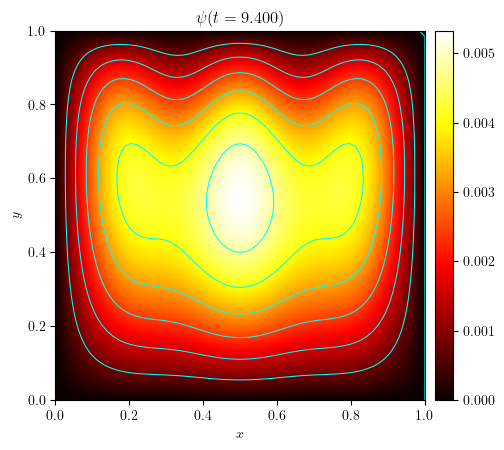

In [ ]:
psi = simulation['psi']
time_index = -1

fig, ax = plot_colormap(psi.series[-1], title=f'$\psi(t={psi.time_series[-1]:.3f})$', x_label='$x$', y_label='$y$')
plot_contours(fig, ax, psi.series[time_index], use_cache=True, colors='cyan')
write(fig, f'A14_navier_stokes_streamfunction_vorticity', './figures', close=False, pickle=False)